# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

## inits

In [1]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\stim_dataset.h5'
model_name = r'D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5'
validation_split=0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time

data_generator = DataGenerator(dataset, zeros_to_nan=True)

%load_ext autoreload
%autoreload 2

## view sample frame

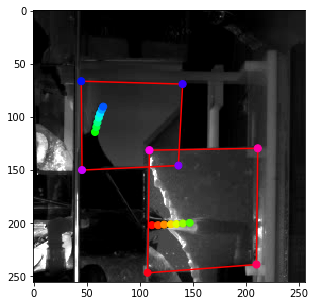

21


In [3]:
frame_num = np.random.choice(len(data_generator))
# frame_num = 1

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)

## set up image augmentation

In [4]:
# settings
rotation = (-20, 20)

augmenter, sometimes = [], []
# todo: add brightness

sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


## show augmentation example

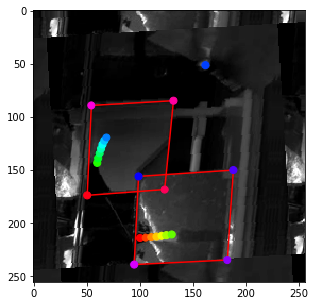

In [5]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [6]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=validation_split, 
                                    use_graph=True,
                                    graph_scale=1)
train_generator.get_config()

D:\github\DeepPoseKit\deepposekit\io\TrainingGenerator.py:177: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


{'n_train': 20,
 'n_validation': 0,
 'validation_split': 0,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 50,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (23, 2)}

# check `TrainingGenerator` output

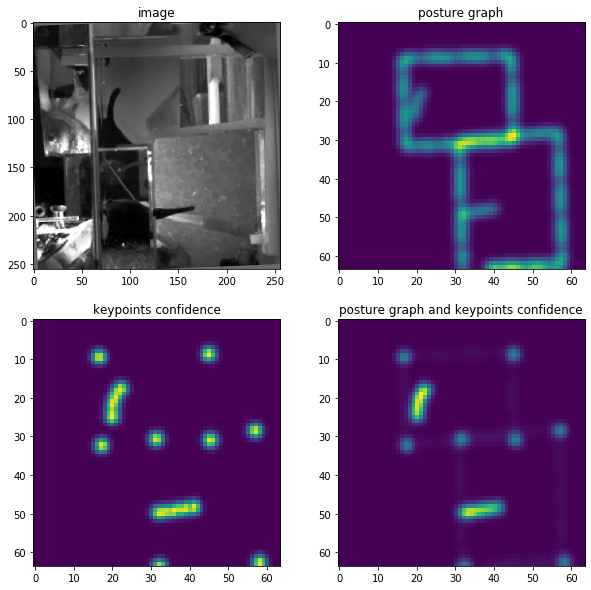

In [7]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# define a model

In [8]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 20,
 'n_validation': 0,
 'validation_split': 0,
 'downsample_factor': 2,
 'output_shape': (64, 64),
 'n_output_channels': 50,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\stim_dataset.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (256, 256, 1),
 'keypoints_shape': (23, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [11]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=100)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 28s 3ms/sample
357.0072047241789


# define training callbacks

In [18]:
logger = Logger(validation_batch_size=5,
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [early_stop, reduce_lr, model_checkpoint]
if validation_split>0:
    callbacks.append(logger)

# train

In [23]:
model.fit(
    batch_size=5,
    validation_batch_size=5,
    callbacks=callbacks,
    epochs=200,
    n_workers=8,
    steps_per_epoch=20,
)

D:\github\DeepPoseKit\deepposekit\models\engine.py:145: UserWarning: 
Automatically compiling with default settings: model.compile('adam', 'mse')
Call model.compile() manually to use non-default settings.

  """\nAutomatically compiling with default settings: model.compile('adam', 'mse')\n"""
D:\github\DeepPoseKit\deepposekit\io\TrainingGenerator.py:227: UserWarning: `validation_split` is 0, so there will be no validation step. callbacks that rely on `val_loss` should be switched to `loss` or removed.
  "`validation_split` is 0, so there will be no validation step. "
D:\github\DeepPoseKit\deepposekit\models\engine.py:161: UserWarning: No validation set detected, so validation step will not be run and `val_loss` will not be available.
  "No validation set detected, so validation step will not be run and `val_loss` will not be available."


Epoch 1/200
19/20 [===========================>..] - ETA: 1s - loss: 280.5907 - output_0_loss: 103.4088 - output_1_loss: 90.5414 - output_2_loss: 86.6405
Epoch 00001: loss improved from inf to 277.77598, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 44s 2s/step - loss: 277.7760 - output_0_loss: 102.9597 - output_1_loss: 89.3048 - output_2_loss: 85.5116
Epoch 2/200
19/20 [===========================>..] - ETA: 0s - loss: 189.5191 - output_0_loss: 84.8622 - output_1_loss: 52.6776 - output_2_loss: 51.9793 ETA: 2s - loss: 196.8852 - output_0_loss: 88.4286 - output_1_loss: 54.6723 - output_2
Epoch 00002: loss improved from 277.77598 to 188.25959, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================] - 9s 428ms/step - loss: 188.2596 - output_0_loss: 84.3811 - output_1_loss: 52.3124 - output_2_loss: 51.5662
Epoch 3/200
19/20 [===========================>..] - ETA: 0s

Epoch 20/200
19/20 [===========================>..] - ETA: 0s - loss: 51.2682 - output_0_loss: 25.2754 - output_1_loss: 14.5497 - output_2_loss: 11.4430
Epoch 00020: loss did not improve from 47.31822
20/20 [==============================] - 10s 477ms/step - loss: 50.9713 - output_0_loss: 25.1820 - output_1_loss: 14.4727 - output_2_loss: 11.3166
Epoch 21/200
19/20 [===========================>..] - ETA: 0s - loss: 50.1085 - output_0_loss: 24.3373 - output_1_loss: 14.4106 - output_2_loss: 11.3606
Epoch 00021: loss did not improve from 47.31822
20/20 [==============================] - 10s 491ms/step - loss: 50.0273 - output_0_loss: 24.3203 - output_1_loss: 14.3724 - output_2_loss: 11.3346
Epoch 22/200
19/20 [===========================>..] - ETA: 0s - loss: 46.1771 - output_0_loss: 23.0473 - output_1_loss: 12.8722 - output_2_loss: 10.2576
Epoch 00022: loss improved from 47.31822 to 46.21020, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [================

19/20 [===========================>..] - ETA: 0s - loss: 21.9419 - output_0_loss: 12.4409 - output_1_loss: 5.2370 - output_2_loss: 4.2639
Epoch 00062: loss did not improve from 20.93259
20/20 [==============================] - 10s 481ms/step - loss: 22.1908 - output_0_loss: 12.4725 - output_1_loss: 5.3140 - output_2_loss: 4.4043
Epoch 63/200
19/20 [===========================>..] - ETA: 0s - loss: 22.2529 - output_0_loss: 12.4311 - output_1_loss: 5.4545 - output_2_loss: 4.3673
Epoch 00063: loss did not improve from 20.93259
20/20 [==============================] - 10s 497ms/step - loss: 22.5959 - output_0_loss: 12.5684 - output_1_loss: 5.5939 - output_2_loss: 4.4336
Epoch 64/200
19/20 [===========================>..] - ETA: 0s - loss: 25.4072 - output_0_loss: 13.3323 - output_1_loss: 6.4089 - output_2_loss: 5.6660
Epoch 00064: loss did not improve from 20.93259
20/20 [==============================] - 10s 503ms/step - loss: 25.1932 - output_0_loss: 13.2695 - output_1_loss: 6.3413 - out

Epoch 85/200
19/20 [===========================>..] - ETA: 0s - loss: 16.8264 - output_0_loss: 9.2924 - output_1_loss: 4.1276 - output_2_loss: 3.4064
Epoch 00085: loss did not improve from 15.30163
20/20 [==============================] - 10s 489ms/step - loss: 16.8063 - output_0_loss: 9.3238 - output_1_loss: 4.1023 - output_2_loss: 3.3802
Epoch 86/200
19/20 [===========================>..] - ETA: 0s - loss: 15.6691 - output_0_loss: 8.9848 - output_1_loss: 3.6720 - output_2_loss: 3.0123
Epoch 00086: loss did not improve from 15.30163
20/20 [==============================] - 10s 493ms/step - loss: 15.5424 - output_0_loss: 8.8717 - output_1_loss: 3.6600 - output_2_loss: 3.0107
Epoch 87/200
19/20 [===========================>..] - ETA: 0s - loss: 14.1250 - output_0_loss: 8.1897 - output_1_loss: 3.2964 - output_2_loss: 2.6390
Epoch 00087: loss improved from 15.30163 to 14.07512, saving model to D:\\github\\fish-tracking\\train\\models\\stim_model_1.h5
20/20 [==============================]

Epoch 131/200
19/20 [===========================>..] - ETA: 0s - loss: 13.3362 - output_0_loss: 6.6721 - output_1_loss: 3.5520 - output_2_loss: 3.1120
Epoch 00131: loss did not improve from 10.51811
20/20 [==============================] - 10s 493ms/step - loss: 13.1900 - output_0_loss: 6.6109 - output_1_loss: 3.5217 - output_2_loss: 3.0573
Epoch 132/200
19/20 [===========================>..] - ETA: 0s - loss: 11.8753 - output_0_loss: 6.2417 - output_1_loss: 3.1075 - output_2_loss: 2.5260
Epoch 00132: loss did not improve from 10.51811
20/20 [==============================] - 10s 479ms/step - loss: 11.8294 - output_0_loss: 6.2272 - output_1_loss: 3.0908 - output_2_loss: 2.5114
Epoch 133/200
19/20 [===========================>..] - ETA: 0s - loss: 13.0713 - output_0_loss: 6.5213 - output_1_loss: 3.5490 - output_2_loss: 3.0010
Epoch 00133: loss did not improve from 10.51811
20/20 [==============================] - 10s 477ms/step - loss: 13.4286 - output_0_loss: 6.7261 - output_1_loss: 3.

Epoch 155/200
19/20 [===========================>..] - ETA: 0s - loss: 30.5402 - output_0_loss: 14.3395 - output_1_loss: 8.5064 - output_2_loss: 7.6942
Epoch 00155: loss did not improve from 10.42163
20/20 [==============================] - 10s 482ms/step - loss: 30.6769 - output_0_loss: 14.2833 - output_1_loss: 8.5890 - output_2_loss: 7.8046
Epoch 156/200
19/20 [===========================>..] - ETA: 0s - loss: 20.4034 - output_0_loss: 10.2491 - output_1_loss: 5.3810 - output_2_loss: 4.7733
Epoch 00156: loss did not improve from 10.42163
20/20 [==============================] - 10s 476ms/step - loss: 20.4721 - output_0_loss: 10.2577 - output_1_loss: 5.4069 - output_2_loss: 4.8074
Epoch 157/200
19/20 [===========================>..] - ETA: 0s - loss: 17.7515 - output_0_loss: 8.4637 - output_1_loss: 4.9169 - output_2_loss: 4.3710
Epoch 00157: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00157: loss did not improve from 10.42163
20/20 [======================

20/20 [==============================] - 10s 493ms/step - loss: 8.6584 - output_0_loss: 5.1450 - output_1_loss: 1.9758 - output_2_loss: 1.5376
Epoch 178/200
19/20 [===========================>..] - ETA: 0s - loss: 8.9844 - output_0_loss: 5.4190 - output_1_loss: 2.0181 - output_2_loss: 1.5473
Epoch 00178: loss did not improve from 8.65841
20/20 [==============================] - 10s 484ms/step - loss: 9.0706 - output_0_loss: 5.4683 - output_1_loss: 2.0387 - output_2_loss: 1.5636
Epoch 179/200
19/20 [===========================>..] - ETA: 0s - loss: 9.4328 - output_0_loss: 5.4365 - output_1_loss: 2.2216 - output_2_loss: 1.7747
Epoch 00179: loss did not improve from 8.65841
20/20 [==============================] - 10s 480ms/step - loss: 9.4616 - output_0_loss: 5.4826 - output_1_loss: 2.2211 - output_2_loss: 1.7579
Epoch 180/200
19/20 [===========================>..] - ETA: 0s - loss: 9.2579 - output_0_loss: 5.4403 - output_1_loss: 2.1570 - output_2_loss: 1.6605
Epoch 00180: loss did not i

# troubleshoot `graph_to_edges`

In [117]:
from deepposekit.utils.keypoints import graph_to_edges
data_generator = DataGenerator(r'D:\github\fish-tracking\label\datasets\stim_dataset.h5')

graph = data_generator.graph.copy()
edge_labels = graph_to_edges(graph)
print(f'graph:  {graph}')
print(f'edglab: {edge_labels}')

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 15: 18, 16: 15, 17: 16, 18: 17, 19: 22, 20: 19, 21: 20, 22: 21}
graph:  [-1  0  1  2  3  4  5 -1  7  8  9 10 11 12 -1 18 15 16 17 22 19 20 21]
edglab: [ 0  0  0  0  0  0  0  7  7  7  7  7  7  7 14 23 23 23 23 24 24 24 24]


In [102]:
any([False, False])

False